Smart Expense Tracker with Python and ollama

In [1]:
# Load data

import pandas as pd

df = pd.read_csv("archive/expense_data_1.csv")
print(df.head())

               Date               Account        Category  Subcategory  \
0  03-02-2022 10:11  CUB - online payment            Food          NaN   
1  03-02-2022 10:11  CUB - online payment           Other          NaN   
2  03-01-2022 19:50  CUB - online payment            Food          NaN   
3  03-01-2022 18:56  CUB - online payment  Transportation          NaN   
4  03-01-2022 18:22  CUB - online payment            Food          NaN   

               Note    INR Income/Expense  Note.1  Amount Currency  Account.1  
0           Brownie   50.0        Expense     NaN    50.0      INR       50.0  
1  To lended people  300.0        Expense     NaN   300.0      INR      300.0  
2            Dinner   78.0        Expense     NaN    78.0      INR       78.0  
3             Metro   30.0        Expense     NaN    30.0      INR       30.0  
4            Snacks   67.0        Expense     NaN    67.0      INR       67.0  


In [2]:
# clean data- keep only relevant columns
data = df[["Date", "Category", "Note", "Amount", "Income/Expense"]]
print(data.head())

               Date        Category              Note  Amount Income/Expense
0  03-02-2022 10:11            Food           Brownie    50.0        Expense
1  03-02-2022 10:11           Other  To lended people   300.0        Expense
2  03-01-2022 19:50            Food            Dinner    78.0        Expense
3  03-01-2022 18:56  Transportation             Metro    30.0        Expense
4  03-01-2022 18:22            Food            Snacks    67.0        Expense


In [3]:
def add_expense(date, category, note, amount, exp_type="Expense"):
    global data
    new_entry = {
        "Date": date,
        "Category": category,
        "Note": note,
        "Amount": amount,
        "Income/Expense": exp_type
    }
    data = pd.concat([data, pd.DataFrame([new_entry])], ignore_index=True)
    print(f" Added: {note} - {amount} ({category})")

    

In [4]:
add_expense("2025-12-22 19:30", "Food", "Shawarma", 2500, "Expense")
add_expense("2025-12-23 08:00", "Subscriptions", "Netflix Monthly Plan", 4500, "Expense")
add_expense("2025-12-24 14:00", "Entertainment", "Outdoor Games with friends", 7000, "Expense")

 Added: Shawarma - 2500 (Food)
 Added: Netflix Monthly Plan - 4500 (Subscriptions)
 Added: Outdoor Games with friends - 7000 (Entertainment)


In [5]:
def view_expenses(n=5):
    return data.tail(n)
print(view_expenses(5))

                 Date       Category                        Note  Amount  \
276  11/21/2021 13:30          Other               Got from joe   2000.0   
277        01-02-2026           Food                       Pizza  1900.0   
278  2025-12-22 19:30           Food                    Shawarma  2500.0   
279  2025-12-23 08:00  Subscriptions        Netflix Monthly Plan  4500.0   
280  2025-12-24 14:00  Entertainment  Outdoor Games with friends  7000.0   

    Income/Expense  
276         Income  
277        Expense  
278        Expense  
279        Expense  
280        Expense  


In [6]:
def summarize_expenses(by="Category"):
    summary = data[data["Income/Expense"]=="Expense"].groupby(by)["Amount"].sum()
    return summary.sort_values(ascending=False)
print(summarize_expenses())

Category
Food                27796.76
Household           12188.00
Transportation       9203.80
Entertainment        7000.00
Other                5117.00
Subscriptions        4500.00
Apparel              3388.00
Social Life          2513.72
Education            1400.00
Self-development      400.00
Beauty                196.00
Gift                  115.00
Name: Amount, dtype: float64


Auto-Categorization with LLM

In [7]:
from openai import OpenAI
MODEL = "llama3.2"
client = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

# We use an LLM to read the Note column 
# and then automatically assign the most relevant Category.

def auto_categorize(note):
    prompt = f"""
    Categorize this expense note into one of these categories: 
    Food, Transportation, Entertainment, Other.
    Note: {note}
    """
    try:
        response = client.chat.completions.create(
            model= MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return "Other"

data['Category'] = data.apply(
    lambda row: auto_categorize(row['Note']) if pd.isna(row['Category']) else row['Category'],
    axis=1
)
print(data[['Note', 'Category']].head(10))

               Note        Category
0           Brownie            Food
1  To lended people           Other
2            Dinner            Food
3             Metro  Transportation
4            Snacks            Food
5        From vicky           Other
6          From dad           Other
7             Pizza            Food
8       From kumara           Other
9             Lunch            Food


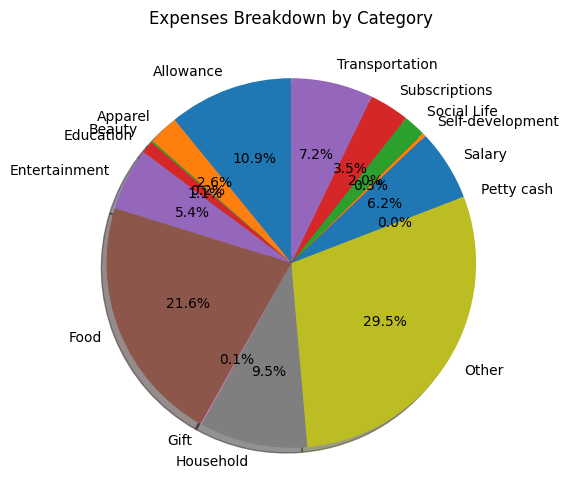

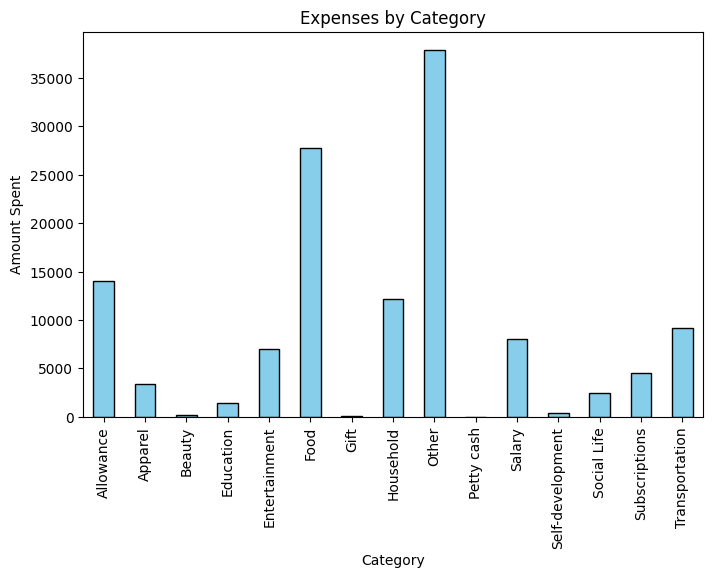

In [8]:
# Visualize expenses
import matplotlib.pyplot as plt
expense_summary = data[data['Category'] != 'Income'].groupby("Category")["Amount"].sum()

# Pie Chart
plt.figure(figsize=(6,6))
expense_summary.plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
plt.title("Expenses Breakdown by Category")
plt.ylabel("")
plt.show()

# Bar Chart
plt.figure(figsize=(8,5))
expense_summary.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Expenses by Category")
plt.xlabel("Category")
plt.ylabel("Amount Spent")
plt.show()